In [110]:
# Digital Image Processing
# Course Project
# Muhammad Ali
# 21I-0887
# A


# Load libraries
import numpy as np
import os
import cv2
from time import time
import matplotlib.pyplot as plt

# Importing necessary functions/classes from scikit-learn
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder  # For encoding labels into numeric format
from sklearn.utils import class_weight  # For calculating class weights
from sklearn.metrics import confusion_matrix, precision_score, recall_score  # For evaluating model performance

# Importing necessary functions/classes from Keras
from keras.models import Model, Sequential, load_model  # For defining and loading neural network models
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Flatten, Dense  # Different layers for building neural networks
from keras.optimizers import Adam  # Optimizer for training the model
from keras.utils import to_categorical  # For one-hot encoding of labels
from keras.losses import binary_crossentropy, categorical_crossentropy  # Different loss functions
from keras.metrics import MeanIoU, Precision, Recall, TrueNegatives, FalsePositives, FalseNegatives, PrecisionAtRecall, RecallAtPrecision  # Evaluation metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping  # Callbacks during training
import keras.backend as K  # Keras backend for low-level operations

# Importing necessary functions/classes from Google Colab
from google.colab import drive  # For mounting Google Drive
from google.colab.patches import cv2_imshow  # For displaying images

In [111]:
# Define maximum length and width of the images
MAX_LENGTH = 128
MAX_WIDTH = 128

# Number of color channels in the images
CHANNELS = 3

# Set a seed for reproducibility
seed = 10
np.random.seed = seed


In [112]:
# Mount Google Drive to access data if using Google Colab
drive.mount('/content/drive')

# Define the path where the data is located in Google Drive
data_path = "/content/drive/My Drive/RIGA 200 Images"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Define a custom function to transform pixel values
def transform_value(value):
    if value < 1:  # If pixel value is less than 1
        return 0  # Set pixel value to 0
    elif 1 <= value <= 140:  # If pixel value is between 1 and 140 (inclusive)
        return 128  # Set pixel value to 128
    else:  # If pixel value is greater than 140
        return 255  # Set pixel value to 255

# Vectorize the custom function to apply it element-wise to an array
vectorized_transform = np.vectorize(transform_value)


In [114]:
# Load and preprocess data
def load_data(data_path, image_ext=".png", mask_ext=".tif"):
    # Get a list of image files and mask files in the specified directory
    image_files = [f for f in os.listdir(data_path) if f.endswith(image_ext)]
    mask_files = [f for f in os.listdir(data_path) if f.endswith(mask_ext)]

    # Initialize lists to store images, masks, and modified masks
    images = []
    masks = []
    modifiedMasks = []

    # Iterate over each image file
    for image_file in image_files:
        # Get the full path of the image
        img_path = os.path.join(data_path, image_file)

        # Generate the corresponding mask file name
        mask_file = image_file.split('.')[0] + mask_ext
        # Get the full path of the mask
        mask_path = os.path.join(data_path, mask_file)

        # Check if the mask file exists
        if os.path.exists(mask_path):
            # Read the image in BGR format
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # Convert the image to YCrCb color space
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            # Read the mask in grayscale
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize image and mask to match specified dimensions
            img = cv2.resize(img, (MAX_LENGTH, MAX_WIDTH))
            mask = cv2.resize(mask, (MAX_LENGTH, MAX_WIDTH))

            # Standardize the image by centering its pixels
            img = (img - np.mean(img)) / np.std(img)

            # Append the preprocessed image and mask to their respective lists
            images.append(img)
            masks.append(mask)

            # Create a copy of the mask for modification
            modifiedMasks.append(masks[-1])

            # Apply the vectorized transform function to the modified mask
            modifiedMasks[-1] = vectorized_transform(modifiedMasks[-1])

    # Convert lists to NumPy arrays
    return np.array(images), np.array(masks), np.array(modifiedMasks)


In [115]:
# Define U-Net model
def unet_model(input_shape):
    # Define input layer
    inputs = Input(input_shape)

    # Encoder
    # First convolutional block
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Second convolutional block
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # Third convolutional block
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # Fourth convolutional block
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    # Fifth convolutional block (bottleneck)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    # First upsampling block
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    # Second upsampling block
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)

    # Third upsampling block
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    # Fourth upsampling block
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)

    # Output layer
    # Change the number of output channels to 3 for multi-class classification and the activation to 'softmax'
    conv10 = Conv2D(3, 1, activation='softmax')(conv9)

    # Create and return the model
    model = Model(inputs=inputs, outputs=conv10)
    return model


In [116]:
# Load data
# Load images and their corresponding modified masks from the specified data path
X, y, modifiedMasks = load_data(data_path)

# Initialize a LabelEncoder object
labelEncoder = LabelEncoder()

# Get the dimensions of the modified masks array
n, h, w = modifiedMasks.shape

# Reshape the modified masks array to a 2D array
modifiedMasks_reshaped = modifiedMasks.reshape(-1, 1)

# Encode the values of the modified masks using LabelEncoder
modifiedMasks_reshaped_encoded = labelEncoder.fit_transform(modifiedMasks_reshaped)

# Reshape the encoded array back to its original shape
modifiedMasks = modifiedMasks_reshaped_encoded.reshape(n, h, w)

# Split data into training and testing sets
# Split the data into training and testing sets with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, modifiedMasks, test_size=0.2, random_state=42)

# Convert labels to categorical format
# Convert the labels in y_train to categorical format with 3 classes
y_train = to_categorical(y_train, 3)

# Convert the labels in y_test to categorical format with 3 classes
y_test = to_categorical(y_test, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


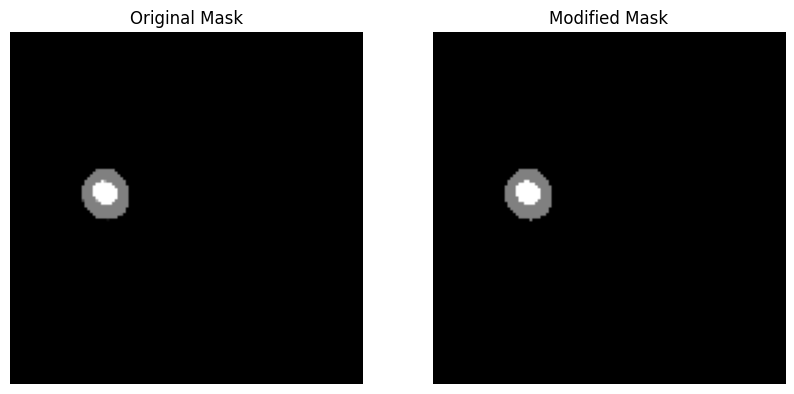

In [117]:
# Generate a random index within the range of the labels array length
idx = np.random.randint(0, len(y))

# Get the original mask and modified mask corresponding to the random index
mask = y[idx]  # Original mask
mm = modifiedMasks[idx]  # Modified mask

# Plot the original image and the modified masks
plt.figure(figsize=(10, 5))

# Original mask
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

# Modified mask
plt.subplot(1, 2, 2)
plt.imshow(mm, cmap='gray')
plt.title('Modified Mask')
plt.axis('off')

# Show the plot
plt.show()


In [118]:
# Define U-Net model
# Define input shape based on MAX_LENGTH, MAX_WIDTH, and CHANNELS
input_shape = (MAX_LENGTH, MAX_WIDTH, CHANNELS)

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model
# Use Adam optimizer with default learning rate
# Use categorical cross-entropy as the loss function for multi-class classification
# Use MeanIoU, accuracy, Precision, and Recall as metrics
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=[MeanIoU(num_classes=3), 'accuracy', Precision(), Recall()])

# Define callbacks
# ModelCheckpoint: Save the model with the highest mean IoU during validation
# EarlyStopping: Stop training if there is no improvement in mean IoU for 5 consecutive epochs
checkpoint = ModelCheckpoint('unet_optic_disk_segmentation.keras', monitor='val_mean_io_u_3', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Print the summary of the model architecture
print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_40[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 64, 64, 128)          73856     ['max_pooling2d_16[0][0]

In [119]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50
5/5 [==============================] - 5s 157ms/step - loss: 0.2477 - mean_io_u_4: 0.3333 - accuracy: 0.9267 - precision_4: 0.9626 - recall_4: 0.8924
Epoch 2/50
5/5 [==============================] - 1s 143ms/step - loss: 0.0767 - mean_io_u_4: 0.4024 - accuracy: 0.9825 - precision_4: 0.9842 - recall_4: 0.9812
Epoch 3/50
5/5 [==============================] - 1s 143ms/step - loss: 0.0620 - mean_io_u_4: 0.4246 - accuracy: 0.9834 - precision_4: 0.9875 - recall_4: 0.9794
Epoch 4/50
5/5 [==============================] - 1s 142ms/step - loss: 0.0550 - mean_io_u_4: 0.4423 - accuracy: 0.9844 - precision_4: 0.9860 - recall_4: 0.9829
Epoch 5/50
5/5 [==============================] - 1s 142ms/step - loss: 0.0507 - mean_io_u_4: 0.4437 - accuracy: 0.9848 - precision_4: 0.9862 - recall_4: 0.9836
Epoch 6/50
5/5 [==============================] - 1s 144ms/step - loss: 0.0422 - mean_io_u_4: 0.4491 - accuracy: 0.9858 - precision_4: 0.9885 - recall_4: 0.9832
Epoch 7/50
5/5 [==================

In [120]:
# Evaluate the model on the test data
test_loss, test_iou, accuracy, prec, rec = model.evaluate(X_test, y_test, verbose=0)  # Evaluate the model
end = time()  # Record the end time

# Print the evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {prec:.4f}, Test Recall: {rec:.4f}')

# Save the trained model
# model.save('/content/drive/MyDrive/UNET MODELS/unet_optic_disk_segmentation_final_HSV.keras')


Test Loss: 0.0112, Test IoU: 0.7883, Test Accuracy: 0.9955, Test Precision: 0.9955, Test Recall: 0.9955


In [121]:
# Evaluate the model on the test data
t0 = time()  # Record the start time
predicted_mask = model.predict(np.expand_dims(X_test[0], axis=0))[0]
end = time()  # Record the end time

# Calculate the time taken for evaluation in milliseconds
time_diff_ms = (end - t0) * 100
print("Time taken:", time_diff_ms, "milliseconds")

1/1 [==============================] - 0s 282ms/step
Time taken: 35.89324951171875 milliseconds


In [122]:
# Load Saved trained Model
# model = load_model('/content/drive/MyDrive/UNET MODELS/unet_optic_disk_segmentation_final_YCrCb.keras')

In [123]:
sum_errors = 0  # Initialize variable to store the sum of errors

# Loop through each image in the test set
for idx in range(len(X_test)):

    # Select an image from X_test and its corresponding ground truth mask
    image = X_test[idx]
    mask = y_test[idx]

    # Perform inference to obtain the predicted mask
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

    # Convert the predicted mask to grayscale
    grayscale_mask = np.dot(predicted_mask[..., :3], [0.2989, 0.5870, 0.1140])

    # Scale the grayscale mask to the range [0, 255]
    scaled_mask = grayscale_mask * 255

    # Extract pixels for optic disc and cup based on threshold values
    extracted_pixels_disk = np.where(scaled_mask > 140, scaled_mask, 255)
    extracted_pixels_cup = np.where(scaled_mask > 70, scaled_mask, 0)

    # Set non-disk pixels to 255 (white)
    maskCup = extracted_pixels_cup != 0
    extracted_pixels_cup[maskCup] = 255

    # Count total non-white pixels for disk and cup
    total_pixels_not_255_disk = np.count_nonzero(extracted_pixels_disk != 255)
    total_pixels_not_255_cup = np.count_nonzero(extracted_pixels_cup != 255)

    # Calculate total pixels for disk and cup
    totalDisk = total_pixels_not_255_disk + total_pixels_not_255_cup
    totalCup = total_pixels_not_255_cup

    # Calculate the cup-to-disk ratio (CDR)
    ratioPred = totalCup / (totalDisk + 1)


    # Calculate the total non-white pixels in the original mask for disk and cup
    grayscale_original = np.dot(mask[..., :3], [0.2989, 0.5870, 0.1140])
    original_scaled = grayscale_original * 255
    original_scaled = cv2.convertScaleAbs(original_scaled)
    total_pixels_original_disk = np.count_nonzero(original_scaled == 150)
    total_pixels_original_cup = np.count_nonzero(original_scaled == 29)

    # Calculate total pixels for disk and cup in the original mask
    totalDiskOriginal = total_pixels_original_disk + total_pixels_original_cup
    totalCupOriginal = total_pixels_original_cup

    # Calculate the original cup-to-disk ratio (CDR)
    ratioPredOriginal = totalCupOriginal / totalDiskOriginal

    # Calculate the error between the predicted and original CDRs
    error = (ratioPredOriginal - ratioPred) / (ratioPred + 1)
    error = abs(error)

    print('Errors: ', error)

    # Accumulate the error
    sum_errors += error

1/1 [==============================] - 0s 27ms/step
Errors:  0.018611218072134526
1/1 [==============================] - 0s 27ms/step
Errors:  0.004115226337448541
1/1 [==============================] - 0s 33ms/step
Errors:  0.004867302568597821
1/1 [==============================] - 0s 29ms/step
Errors:  0.019588293941704298
1/1 [==============================] - 0s 28ms/step
Errors:  0.05930796307365344
1/1 [==============================] - 0s 27ms/step
Errors:  0.025595686706475756
1/1 [==============================] - 0s 38ms/step
Errors:  0.04187925170068024
1/1 [==============================] - 0s 21ms/step
Errors:  0.13900134952766535
1/1 [==============================] - 0s 18ms/step
Errors:  0.031093786656560738
1/1 [==============================] - 0s 19ms/step
Errors:  0.056711218303018125
1/1 [==============================] - 0s 19ms/step
Errors:  0.019740663622309012
1/1 [==============================] - 0s 18ms/step
Errors:  0.10531303497187576
1/1 [===============

In [124]:
# Perform predictions on the test set
y_pred = model.predict(X_test)

# Get the index of the highest predicted class probability for each pixel
y_pred_argmax = np.argmax(y_pred, axis=3)


1/1 [==============================] - 0s 20ms/step


In [125]:
y_pred_binary = (y_pred > 0.1).astype(int)
y_test_binary = (y_test > 0.1).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate precision, recall, accuracy
precision = precision_score(y_test_binary.flatten(), y_pred_binary.flatten())
recall = recall_score(y_test_binary.flatten(), y_pred_binary.flatten())
accuracy = (TP + TN) / (TP + FP + TN + FN)

In [126]:
# Display the metrics

# Print the average relative error
print('Average Relative Error: ', sum_errors/len(X_test))

# Print the test metrics
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Accuracy: {accuracy:.4f}')

# Print precision and recall
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

# Print true positives, false positives, true negatives, false negatives
print(f'True Positives: {TP}, False Positives: {FP}, True Negatives: {TN}, False Negatives: {FN}')


Average Relative Error:  0.047920540627676825
Test Loss: 0.0112, Test IoU: 0.7883, Test Accuracy: 0.9960
Precision: 0.9895, Recall: 0.9986
True Positives: 327233, False Positives: 3477, True Negatives: 651883, False Negatives: 447


1/1 [==============================] - 0s 18ms/step


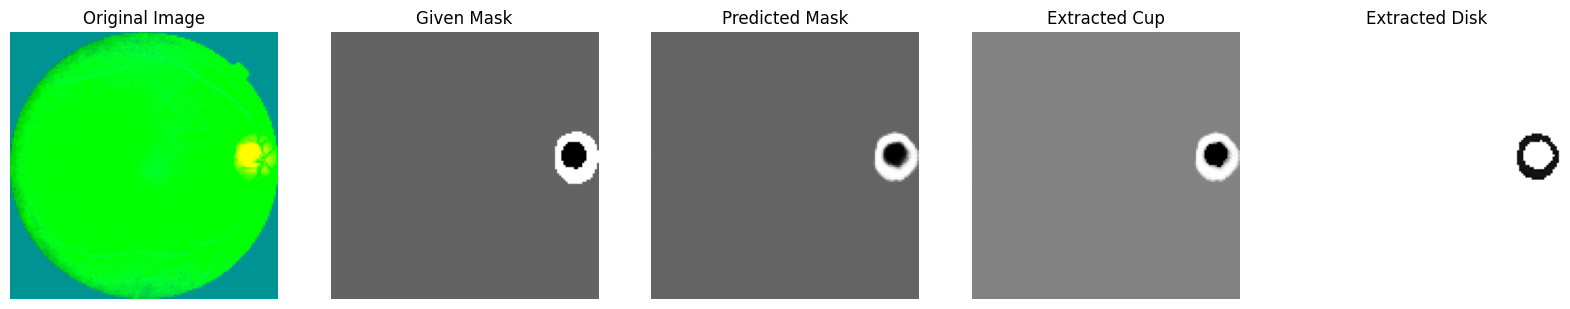

In [127]:
idx = np.random.randint(0, len(X_test))


# Select an image and its corresponding ground truth mask from X_test and y_test
image = X_test[idx]
mask = y_test[idx]

# Perform inference to obtain the predicted mask
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Convert the predicted mask to grayscale
grayscale_mask = np.dot(predicted_mask[..., :3], [0.2989, 0.5870, 0.1140])

# Scale the grayscale mask to the range [0, 255]
scaled_mask = grayscale_mask * 255

# Extract pixels for the optic disc and cup based on threshold values
extracted_pixels_disk = np.where(scaled_mask > 140, scaled_mask, 255)
extracted_pixels_cup = np.where(scaled_mask > 70, scaled_mask, 0)

# Convert the ground truth mask to grayscale
grayscale_original = np.dot(mask[..., :3], [0.2989, 0.5870, 0.1140])

# Scale the grayscale original mask to the range [0, 255]
original_scaled = grayscale_original * 255
original_scaled = cv2.convertScaleAbs(original_scaled)

# Plot the original image and the predicted masks
plt.figure(figsize=(20, 20))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Given Mask
plt.subplot(1, 5, 2)
plt.imshow(original_scaled, cmap='gray')
plt.title('Given Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 5, 3)
plt.imshow(scaled_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

# Extracted Cup
plt.subplot(1, 5, 4)
plt.imshow(extracted_pixels_cup, cmap='gray')
plt.title('Extracted Cup')
plt.axis('off')

# Extracted Disk
plt.subplot(1, 5, 5)
plt.imshow(extracted_pixels_disk, cmap='gray')
plt.title('Extracted Disk')
plt.axis('off')

# Show the plot
plt.show()
